# Machine Learning for Financial Trading EUR/USD

Forex is the biggest market in the world, and EUR/USD is the most common trading currency pair.
This code is an example of applying AI in Forex trading.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

,Gmt time,Open,High,Low,Close,Volume
0,16.04.2019 21:00:00.000,1.12804,1.12878,1.12788,1.12865,23715.2205
1,17.04.2019 01:00:00.000,1.12865,1.13043,1.12839,1.13031,39188.2895
2,17.04.2019 05:00:00.000,1.13032,1.13237,1.13028,1.13159,84122.2500
3,17.04.2019 09:00:00.000,1.13158,1.13193,1.13004,1.13036,99475.6993
4,17.04.2019 13:00:00.000,1.13036,1.13073,1.12907,1.12962,107407.2091


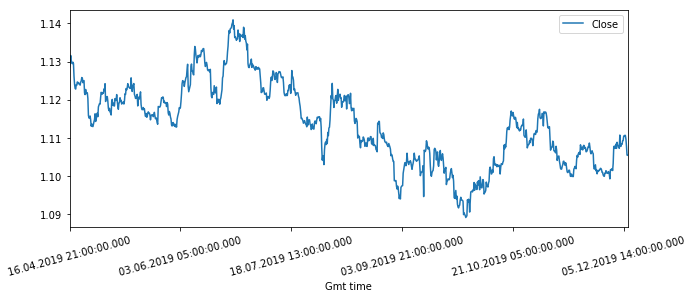

In [2]:
# Put data into Pandas Dataframe
historic_df = pd.read_csv("EURUSD_Candlestick_4_Hour_BID_17.04.2019-06.12.2019.csv")
historic_df = historic_df[historic_df['Volume']>1000]
dates = pd.to_datetime(historic_df['Gmt time'], format="%d.%m.%Y %H:%M:%S.%f")
df = pd.DataFrame(historic_df)
df.head(10)
df.plot(x='Gmt time',y='Close',figsize=(10,4))
plt.xticks(rotation=15)
df.head(5)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text xticklabel objects>)

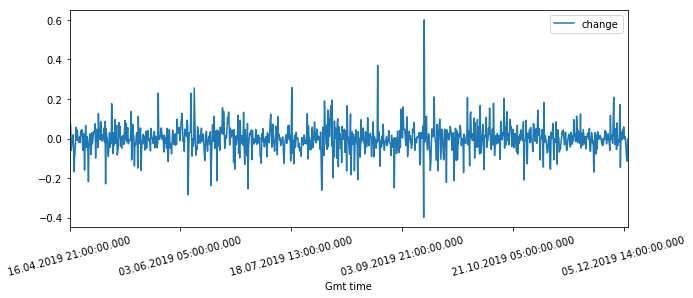

In [3]:
# Normalize Close value
df['change'] = df['Close'] - df['Close'].shift(1)
change_range = df['change'].max() - df['change'].min()
df['change'] = df['change'] / change_range
df.plot(x='Gmt time', y='change', figsize=(10,4))
plt.xticks(rotation=15)

In [4]:
# Labeling the price. We assume 1 as rising price, 0 as falling price
df['label'] = df['change'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.tail()

,Gmt time,Open,High,Low,Close,Volume,change,label
1400,06.12.2019 02:00:00.000,1.11066,1.11089,1.11059,1.11063,7630.2100,-0.000986,0
1401,06.12.2019 06:00:00.000,1.11064,1.11097,1.10951,1.10966,20621.7400,-0.047807,0
1402,06.12.2019 10:00:00.000,1.10965,1.11014,1.10687,1.10781,33711.6100,-0.091178,0
1403,06.12.2019 14:00:00.000,1.10781,1.10790,1.10398,1.10548,41062.5300,-0.114835,0
1404,06.12.2019 18:00:00.000,1.10547,1.10614,1.10504,1.10543,13630.2228,-0.002464,0


In [5]:
# Create the train sets
n_features = 60 # number of features
x_train = np.array([]).reshape([-1,n_features])
y_train = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue    
    _x = np.array(df[i-n_features+1:i+1]['change']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    x_train  = np.vstack((x_train , _x))
    y_train = np.vstack((y_train, _y))
y_train = y_train.reshape([-1])
print(x_train .shape)
print(y_train.shape)

(948, 60)
(948,)


In [6]:
# We use 95% of first data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)
len_train = int(len(x_train)*0.95)
gbc.fit(x_train[:len_train], y_train[:len_train])


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10000,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
accuracy = gbc.score(x_train[len_train:], y_train[len_train:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.479167


In [8]:
# Predict test data
pred = gbc.predict(x_train [len_train:])

In [9]:
# Fund the capital
contracts  = 100000.0 #USD
commission = 7.0 #per lot

,change,label,pred,take profit,pnl,balance
42,-0.00002,0.0,0.0,True,-5.0,-156.0
43,-0.00097,0.0,1.0,False,-104.0,-260.0
44,-0.00185,0.0,0.0,True,178.0,-82.0
45,-0.00233,0.0,0.0,True,226.0,144.0
46,-0.00005,0.0,0.0,True,-2.0,142.0


Text(0,0.5,'Balance (USD)')

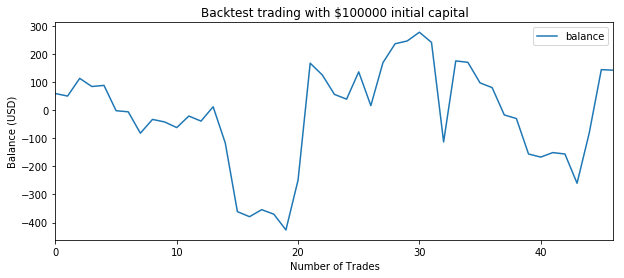

In [10]:
#Let's trade!!!
df_trade = pd.DataFrame(x_train [len_train:,-1], columns=['change'])
df_trade['label']  = y_train[len_train:]
df_trade['pred']   = pred
df_trade['take profit']    = df_trade['label'] == df_trade['pred']
df_trade['change'] = df_trade['change'].shift(-1) * change_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['take profit']:
        return abs(row['change'])*contracts - commission
    else:
        return -abs(row['change'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['balance'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='balance', figsize=(10,4), title='Backtest trading with $100000 initial capital')
plt.xlabel('Number of Trades')
plt.ylabel('Balance (USD)')


Net Profit            : $142.00
Number Winning Trades : 18
Number Losing Trades  : 29
Percent Profitable    : 38.30%
Avg Win Trade         : $108.389
Avg Los Trade         : $-62.379
Largest Win Trade     : $416.000
Largest Los Trade     : $-354.000
Profit Factor         : 1.08


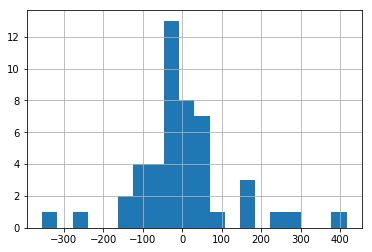

In [11]:
# Create a report as the same as in Metatrader4
n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['balance'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)

## Seem commission drained a lot of profit!!!